SOURCE : [URL](https://www.kaggle.com/utathya/ann-on-electricity-consumption/data)

- ...? 뭔가 이상하다.

In [83]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense

from tensorflow import device

import time
import operator
from datetime import datetime

def datetounix(df):
    df = df.copy()
    
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop to convert Date to seconds
    for date in df['datetime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['datetime'] = unixtime
    return(df)

In [84]:
df_train = pd.read_csv('../data/elec_train.csv')
df_test = pd.read_csv('../data/elec_test.csv')

## what is var1 and var2 ????

print(df_train.head(3),end='\n\n')
print(df_test.head(3))

   ID             datetime  temperature  var1  pressure  windspeed var2  \
0   0  2013-07-01 00:00:00        -11.4 -17.1    1003.0    571.910    A   
1   1  2013-07-01 01:00:00        -12.1 -19.3     996.0    575.040    A   
2   2  2013-07-01 02:00:00        -12.9 -20.0    1000.0    578.435    A   

   electricity_consumption  
0                    216.0  
1                    210.0  
2                    225.0  

    ID             datetime  temperature  var1  pressure  windspeed var2
0  552  2013-07-24 00:00:00        -10.0 -16.4    1011.0    263.280    A
1  553  2013-07-24 01:00:00        -10.0 -20.7    1011.0    267.175    A
2  554  2013-07-24 02:00:00        -10.7 -17.1    1003.0    269.555    A


In [85]:
print(df_train.info(),end='\n\n')
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   datetime                 26496 non-null  object 
 2   temperature              26496 non-null  float64
 3   var1                     26496 non-null  float64
 4   pressure                 26496 non-null  float64
 5   windspeed                26496 non-null  float64
 6   var2                     26496 non-null  object 
 7   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8568 entries, 0 to 8567
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           8568 non-null   int64  
 1   datetime     8568 non-null   object 
 2   tempe

In [86]:
print(df_train.isna().sum(),end='\n\n')
print(df_test.isna().sum())

ID                         0
datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

ID             0
datetime       0
temperature    0
var1           0
pressure       0
windspeed      0
var2           0
dtype: int64


# data cleaning

In [87]:
# to Date
df_train.loc[:,'datetime'] = pd.to_datetime(df_train['datetime'])
df_test.loc[:,'datetime'] = pd.to_datetime(df_test['datetime'])

df_train.loc[:,'weekday'] = df_train['datetime'].dt.weekday
df_train.loc[:,'year'] = df_train['datetime'].dt.year
df_train.loc[:,'month'] = df_train['datetime'].dt.month
df_train.loc[:,'day'] = df_train['datetime'].dt.day
df_train.loc[:,'time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_train['datetime'].tolist()]
df_train.loc[:,'week'] = df_train['datetime'].dt.isocalendar()['week']
df_train.loc[:,'quarter'] = df_train['datetime'].dt.quarter

df_test.loc[:,'weekday'] = df_test['datetime'].dt.weekday
df_test.loc[:,'year'] = df_test['datetime'].dt.year
df_test.loc[:,'month'] = df_test['datetime'].dt.month
df_test.loc[:,'day'] = df_test['datetime'].dt.day
df_test.loc[:,'time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_test['datetime'].tolist()]
df_test.loc[:,'week'] = df_test['datetime'].dt.isocalendar()['week']
df_test.loc[:,'quarter'] = df_test['datetime'].dt.quarter


print(df_train.head(3),end='\n\n')
print(df_test.head(3))

   ID            datetime  temperature  var1  pressure  windspeed var2  \
0   0 2013-07-01 00:00:00        -11.4 -17.1    1003.0    571.910    A   
1   1 2013-07-01 01:00:00        -12.1 -19.3     996.0    575.040    A   
2   2 2013-07-01 02:00:00        -12.9 -20.0    1000.0    578.435    A   

   electricity_consumption  weekday  year  month  day  time  week  quarter  
0                    216.0        0  2013      7    1     0    27        3  
1                    210.0        0  2013      7    1  3600    27        3  
2                    225.0        0  2013      7    1  7200    27        3  

    ID            datetime  temperature  var1  pressure  windspeed var2  \
0  552 2013-07-24 00:00:00        -10.0 -16.4    1011.0    263.280    A   
1  553 2013-07-24 01:00:00        -10.0 -20.7    1011.0    267.175    A   
2  554 2013-07-24 02:00:00        -10.7 -17.1    1003.0    269.555    A   

   weekday  year  month  day  time  week  quarter  
0        2  2013      7   24     0    30 

In [88]:
df_train_cp = df_train.copy()
df_test_cp = df_test.copy()

# Create Dummy Variables 
df_train_cp.loc[df_train_cp['var2'] == 'A', 'var2A'] = 1
df_train_cp.loc[df_train_cp['var2'] == 'B', 'var2B'] = 1
df_train_cp['var2A'].fillna(0, inplace=True)
df_train_cp['var2B'].fillna(0, inplace=True)

df_train_cp.drop(['var2'], axis=1, inplace=True)

df_test_cp.loc[df_test_cp['var2'] == 'A', 'var2A'] = 1
df_test_cp.loc[df_test_cp['var2'] == 'B', 'var2B'] = 1
df_test_cp['var2A'].fillna(0, inplace=True)
df_test_cp['var2B'].fillna(0, inplace=True)

df_test_cp.drop(['var2'], axis=1, inplace=True)

# Remove target column from the df
df_train_features = df_train_cp.drop(['electricity_consumption','ID'], axis=1)
df_train_features = datetounix(df_train_features)

# store features in X array
x = df_train_features
y = df_train_cp['electricity_consumption']

Feature ranking:
feature 0 : datetime (0.147241)
feature 4 : windspeed (0.143732)
feature 9 : time (0.138825)
feature 3 : pressure (0.133278)
feature 1 : temperature (0.124342)
feature 2 : var1 (0.124174)
feature 8 : day (0.063493)
feature 5 : weekday (0.056783)
feature 10 : week (0.032559)
feature 6 : year (0.015557)
feature 7 : month (0.011092)
feature 12 : var2A (0.005803)
feature 11 : quarter (0.002714)
feature 13 : var2B (0.000406)


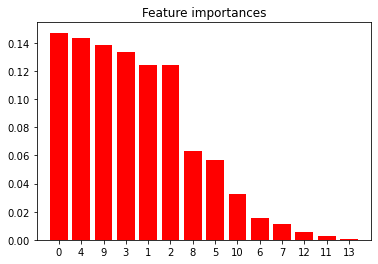

In [89]:
# create an instance for tree feature selection
clf = ExtraTreesClassifier()

# fit the model
clf.fit(x, y)

# Preparing variables
importances = clf.feature_importances_
feature_names = df_train_features.columns.tolist()

feature_imp_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]):
    print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

# Plot the feature importances of the forest
plt.figure(0)
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

In [90]:
x_test = datetounix(df_test_cp).drop(['ID'], axis=1)
sd_scaler = StandardScaler()

x = sd_scaler.fit_transform(x)
x_test = sd_scaler.transform(x_test)

y_norm = (y - min(y))/(max(y) - min(y))
y_norm

0        0.034653
1        0.029703
2        0.042079
3        0.034653
4        0.039604
           ...   
26491    0.042079
26492    0.032178
26493    0.032178
26494    0.029703
26495    0.029703
Name: electricity_consumption, Length: 26496, dtype: float64

In [91]:
# modeling
model = Sequential()

model.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

with device('/device:GPU:0'):
    model_fitted = model.fit(x, y_norm, batch_size = 10, epochs = 100)

# Predicting the Test set results
y_pred = model.predict(x_test)
y_pred = (y_pred * (max(y) - min(y))) + min(y)

Epoch 1/100
2650/2650 [==============================] - 7s 3ms/step - loss: 0.0115 - mae: 0.0689
Epoch 2/100
2650/2650 [==============================] - 7s 3ms/step - loss: 0.0047 - mae: 0.0488
Epoch 3/100
2650/2650 [==============================] - 7s 3ms/step - loss: 0.0046 - mae: 0.0480
Epoch 4/100
2650/2650 [==============================] - 7s 3ms/step - loss: 0.0045 - mae: 0.0476
Epoch 5/100
2650/2650 [==============================] - 7s 3ms/step - loss: 0.0045 - mae: 0.0473
Epoch 6/100
2650/2650 [==============================] - 7s 3ms/step - loss: 0.0045 - mae: 0.0469
Epoch 7/100
2650/2650 [==============================] - 7s 3ms/step - loss: 0.0044 - mae: 0.0468
Epoch 8/100
2650/2650 [==============================] - 7s 3ms/step - loss: 0.0044 - mae: 0.0466
Epoch 9/100
2650/2650 [==============================] - 7s 2ms/step - loss: 0.0044 - mae: 0.0465
Epoch 10/100
2650/2650 [==============================] - 7s 3ms/step - loss: 0.0044 - mae: 0.0464
Epoch 11/100
2650/2

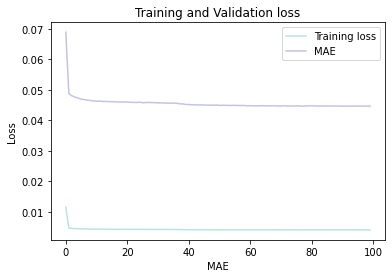

In [96]:
df_history = pd.DataFrame(model_fitted.history)
df_history
plt.plot(df_history.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(df_history.loc[:, ['mae']],"#C2C4E2", label='MAE')
plt.title('Training and Validation loss')

plt.xlabel('MAE')
plt.ylabel('Loss')

plt.legend(loc="best")

In [97]:
predictions = [int(elem) for elem in y_pred]

df_solution = pd.DataFrame()
df_solution['ID'] = df_test.ID

# Prepare Solution dataframe
df_solution['electricity_consumption'] = predictions
df_solution['electricity_consumption'].unique()

df_solution

,ID,electricity_consumption
0,552,210
1,553,189
2,554,204
3,555,189
4,556,271
...,...,...
8563,35059,185
8564,35060,187
8565,35061,185
8566,35062,184
